In [53]:
from __future__ import absolute_import, division, print_function
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow_datasets as tfds
from tqdm import tqdm


import tensorflow as tf
import tensorflow_hub as hub

In [54]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [55]:
splits = ("train[:80]", "train[:10]", "train[:10]")
splits, info = tfds.load('cats_vs_dogs',with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [56]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return image, label

In [57]:
BATCH_SIZE = 32

In [58]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [59]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [60]:
do_fine_tuning=False

In [61]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [62]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([feature_extractor,
                            tf.keras.layers.Dense(num_classes, activation='softmax')])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [63]:
NUM_LAYERS = 10
if do_fine_tuning:
    feature_extractor.trainable=True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable=True
else:
    feature_extractor.trainable=False

In [64]:
if do_fine_tuning:
    model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
else:
    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [65]:
EPOCHS = 5
hist = model.fit(train_batches,
                epochs = EPOCHS,
                validation_data= validation_batches)

Epoch 1/5
3/3 [==============================] - 4s 1s/step - loss: 0.6561 - accuracy: 0.6250 - val_loss: 0.4537 - val_accuracy: 0.9000
Epoch 2/5
3/3 [==============================] - 1s 421ms/step - loss: 0.3867 - accuracy: 0.8625 - val_loss: 0.2656 - val_accuracy: 1.0000
Epoch 3/5
3/3 [==============================] - 1s 417ms/step - loss: 0.2332 - accuracy: 0.9250 - val_loss: 0.1679 - val_accuracy: 1.0000
Epoch 4/5
3/3 [==============================] - 1s 404ms/step - loss: 0.1503 - accuracy: 0.9500 - val_loss: 0.1204 - val_accuracy: 1.0000
Epoch 5/5
3/3 [==============================] - 1s 417ms/step - loss: 0.0993 - accuracy: 0.9875 - val_loss: 0.0859 - val_accuracy: 1.0000


In [66]:
CATS_VS_DOGS_SAVED_MODEL = 'exp_saved_model'

In [67]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


In [68]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_2_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_2_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [69]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [70]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures['serving_default']
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_2_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_2_input')})
{'dense_2': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense_2')}


In [71]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

In [72]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [73]:
def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]

In [74]:
converter.representative_dataset = representative_data_gen

In [75]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [76]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [77]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [78]:
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

10it [00:06,  1.48it/s]


In [79]:
class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

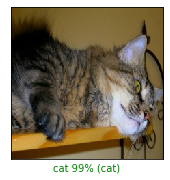

In [91]:
index = 3 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [81]:
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

In [82]:
!mkdir -p test_images

In [83]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [84]:
!ls test_images

cat_3.jpg cat_7.jpg dog_1.jpg dog_4.jpg dog_8.jpg
cat_6.jpg dog_0.jpg dog_2.jpg dog_5.jpg dog_9.jpg


In [85]:
!zip -qq cats_vs_dogs_test_images.zip -r test_images/